In [1]:
import os
import keras
import random
import numpy as np
import pandas as pd
from random import shuffle
from skimage.io import imread
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.models import load_model
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, GlobalAveragePooling2D, Dropout

Using TensorFlow backend.
/home/michael/anaconda3/envs/testenv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/michael/anaconda3/envs/testenv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/michael/anaconda3/envs/testenv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/michael/

In [2]:
# https://www.nature.com/articles/srep27988
# Data usage statement
# We release all raw data under a Creative Commons Attribution 4.0 International License (http://creativecommons.org/licenses/by/4.0/). The data can be accessed via the following DOI: 10.5281/zenodo.53169. All source codes used for this study are available under the MIT license (http://opensource.org/licenses/MIT) and can be accessed via the following DOI: 10.5281/zenodo.53735.
# https://zenodo.org/record/53169
# https://zenodo.org/record/53735

In [3]:
random.seed(69)
train_dir = './train/train/'
test_dir = './test/test'

In [4]:
train_data = pd.read_csv('./train.csv')
train_data['train_file'] = train_data.Id.apply(lambda x: './train/train/{0}'.format(x))

In [5]:
train_df = pd.read_csv('train_df_0.csv')
val_df = pd.read_csv('val_df_0.csv')

In [6]:
print(len(train_df.index), len(val_df.index))

3600 900


In [7]:
print("Num Samples: ", len(train_data.index))
print("Image Shape: ", imread(train_data.iloc[0].train_file).shape)

Num Samples:  4500
Image Shape:  (150, 150, 3)


In [8]:
# Less Agressive
# Shear: https://stackoverflow.com/questions/57301330/what-exactly-the-shear-do-in-imagedatagenerator-of-keras
#  - We dont really need it
# Zoom Range: Zooming out is fine, but zooming in should be careful or we may end up with confusion between that and adipose
# We super dont need as much brightness as we have right now
datagen = ImageDataGenerator(rescale=1/255.,
                             rotation_range=90,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             fill_mode='reflect',
                             zoom_range=[0.8, 1.1],
                             horizontal_flip=True,
                             vertical_flip=True,
                             brightness_range=[0.8, 1.1],
                             channel_shift_range=12)
val_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

In [9]:
train_generator = datagen.flow_from_dataframe(dataframe=train_df, directory=train_dir,
                                             x_col='Id',
                                             y_col='Category',
                                             target_size=(150, 150),
                                             class_mode='categorical',
                                             batch_size=32,
                                             seed=7)

validation_generator = val_datagen.flow_from_dataframe(dataframe=val_df, directory=train_dir,
                                             x_col='Id',
                                             y_col='Category',
                                            shuffle=False,
                                             target_size=(150, 150),
                                             class_mode='categorical',
                                             batch_size=100,
                                             seed=7)

Found 3600 validated image filenames belonging to 8 classes.
Found 900 validated image filenames belonging to 8 classes.


In [10]:
# Easy VGG 16 Base Model (Mainly just for checking if things work)
# model = vgg_16_base((150, 150, 3), 'imagenet', 8)
def vgg_16_base(input_shape, pretrained_weights, num_classes, preds_not_one_hot=False):
    from keras.applications.vgg16 import VGG16
    # Sigmoid squashes each output into 0-1, whereas softmax makes all outputs sum to 1
    final_activation = 'sigmoid' if preds_not_one_hot else 'softmax'
    base_model = VGG16(weights=pretrained_weights, include_top=False, input_shape=input_shape)
    base_out = base_model.output
    pool_out = Flatten()(base_out)
    predictions = Dense(num_classes, activation='softmax')(pool_out)
    return Model(inputs=base_model.input, outputs=predictions)

In [11]:
# Given some model, freeze all layers except the ones between...
def freeze_model_layers(given_model, trainable_start=None, trainable_end=None):
    trainable_end = len(given_model.layers) if trainable_start and not trainable_end else trainable_end
    trainable_start = 0 if trainable_end and not trainable_start else trainable_start
    for layer in given_model.layers:
       layer.trainable = False
    if trainable_start and trainable_end:
        for layer in given_model.layers[trainable_start:trainable_end]:
            layer.trainable = True
    print("Froze all layers except {} to {}.  Model must be compiled after this!".format(trainable_start, trainable_end))

In [12]:
train_steps = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

In [13]:
model = vgg_16_base((150, 150, 3), 'imagenet', 8)
freeze_model_layers(model, trainable_start=19)
# Probabilities produced by softmax will always sum to 1
default_adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
slow_adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss='categorical_crossentropy',optimizer=default_adam,metrics=['accuracy'])

Froze all layers except 19 to 21.  Model must be compiled after this!


In [14]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
mc = ModelCheckpoint('vgg_16_step_1.h5', monitor='val_loss', mode='min', save_best_only=True)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=4, verbose=1, factor=0.5, min_lr=0.0000001)
history = model.fit_generator(train_generator,steps_per_epoch=train_steps, epochs=60,
                              validation_data=validation_generator,validation_steps=validation_steps,
                              callbacks=[es, mc, learning_rate_reduction],
                              workers=6, max_queue_size=30)

Epoch 1/60
112/112 [==============================] - 9s 82ms/step - loss: 0.8032 - acc: 0.7101 - val_loss: 0.5569 - val_acc: 0.7867
Epoch 2/60
112/112 [==============================] - 7s 59ms/step - loss: 0.5249 - acc: 0.8117 - val_loss: 0.5113 - val_acc: 0.8167
Epoch 3/60
112/112 [==============================] - 6s 55ms/step - loss: 0.4853 - acc: 0.8290 - val_loss: 0.3842 - val_acc: 0.8678
Epoch 4/60
112/112 [==============================] - 6s 55ms/step - loss: 0.4379 - acc: 0.8488 - val_loss: 0.4887 - val_acc: 0.8322
Epoch 5/60
112/112 [==============================] - 6s 54ms/step - loss: 0.4385 - acc: 0.8488 - val_loss: 0.3551 - val_acc: 0.8811
Epoch 6/60
112/112 [==============================] - 6s 54ms/step - loss: 0.3945 - acc: 0.8521 - val_loss: 0.3759 - val_acc: 0.8722
Epoch 7/60
112/112 [==============================] - 6s 54ms/step - loss: 0.4061 - acc: 0.8535 - val_loss: 0.3698 - val_acc: 0.8667
Epoch 8/60
112/112 [==============================] - 6s 54ms/step - 

In [15]:
model = load_model("vgg_16_step_1.h5")
freeze_model_layers(model, trainable_start=15, trainable_end=None)
default_adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss='categorical_crossentropy',optimizer=slow_adam,metrics=['accuracy'])

Froze all layers except 15 to 21.  Model must be compiled after this!


In [16]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
mc = ModelCheckpoint('vgg_16_step_2.h5', monitor='val_loss', mode='min', save_best_only=True)
# reduces learning rate if no improvement are seen
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=4, verbose=1, factor=0.5, min_lr=0.0000001)
history = model.fit_generator(train_generator,steps_per_epoch=train_steps, epochs=500,
                              validation_data=validation_generator,validation_steps=validation_steps,
                              callbacks=[es, mc, learning_rate_reduction],
                              workers=6, max_queue_size=30)

Epoch 1/500
112/112 [==============================] - 8s 75ms/step - loss: 0.4815 - acc: 0.8298 - val_loss: 0.3564 - val_acc: 0.8822
Epoch 2/500
112/112 [==============================] - 7s 66ms/step - loss: 0.3480 - acc: 0.8736 - val_loss: 0.2680 - val_acc: 0.8844
Epoch 3/500
112/112 [==============================] - 7s 66ms/step - loss: 0.2929 - acc: 0.8993 - val_loss: 0.3046 - val_acc: 0.8856
Epoch 4/500
112/112 [==============================] - 7s 66ms/step - loss: 0.3325 - acc: 0.8820 - val_loss: 0.2546 - val_acc: 0.8989
Epoch 5/500
112/112 [==============================] - 7s 66ms/step - loss: 0.2461 - acc: 0.9143 - val_loss: 0.2530 - val_acc: 0.8956
Epoch 6/500
112/112 [==============================] - 7s 66ms/step - loss: 0.2581 - acc: 0.9118 - val_loss: 0.2863 - val_acc: 0.8967
Epoch 7/500
112/112 [==============================] - 7s 66ms/step - loss: 0.2354 - acc: 0.9152 - val_loss: 0.2501 - val_acc: 0.9089
Epoch 8/500
112/112 [==============================] - 7s 66ms

In [17]:
model = load_model("vgg_16_step_2.h5")
freeze_model_layers(model, trainable_start=11, trainable_end=None)
default_adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
slow_adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss='categorical_crossentropy',optimizer=slow_adam,metrics=['accuracy'])

Froze all layers except 11 to 21.  Model must be compiled after this!


In [18]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
mc = ModelCheckpoint('vgg_16_step_3.h5', monitor='val_loss', mode='min', save_best_only=True)
# reduces learning rate if no improvement are seen
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=4, verbose=1, factor=0.5, min_lr=0.0000001)
history = model.fit_generator(train_generator,steps_per_epoch=train_steps, epochs=500,
                              validation_data=validation_generator,validation_steps=validation_steps,
                              callbacks=[es, mc, learning_rate_reduction],
                              workers=6, max_queue_size=30)

Epoch 1/500
112/112 [==============================] - 11s 96ms/step - loss: 0.4719 - acc: 0.8482 - val_loss: 0.3660 - val_acc: 0.8722
Epoch 2/500
112/112 [==============================] - 10s 87ms/step - loss: 0.3292 - acc: 0.8831 - val_loss: 0.2798 - val_acc: 0.9100
Epoch 3/500
112/112 [==============================] - 9s 84ms/step - loss: 0.2977 - acc: 0.8934 - val_loss: 0.2321 - val_acc: 0.9222
Epoch 4/500
112/112 [==============================] - 9s 84ms/step - loss: 0.2632 - acc: 0.9096 - val_loss: 0.2496 - val_acc: 0.9122
Epoch 5/500
112/112 [==============================] - 9s 84ms/step - loss: 0.2232 - acc: 0.9230 - val_loss: 0.2889 - val_acc: 0.9078
Epoch 6/500
112/112 [==============================] - 9s 84ms/step - loss: 0.2488 - acc: 0.9104 - val_loss: 0.2464 - val_acc: 0.9267
Epoch 7/500
112/112 [==============================] - 9s 84ms/step - loss: 0.2322 - acc: 0.9166 - val_loss: 0.2266 - val_acc: 0.9256
Epoch 8/500
112/112 [==============================] - 9s 82

In [19]:
saved_model = load_model("vgg_16_step_3.h5")

In [20]:
num_name_dict = {v:k for k,v in train_generator.class_indices.items()}

In [21]:
import matplotlib.pyplot as plt
import itertools
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if cmap is None:
        cmap = plt.get_cmap('Blues')
    plt.figure(figsize=(8*2, 6*2))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.ylim(len(cm)-0.5, -0.5)
    plt.show()

In [22]:
validation_generator.reset()
final_preds = []
final_true = []
for j in range(validation_steps):
    x_val, y_val = next(validation_generator)
    _pred = saved_model.predict(x_val)
    _num_preds = [np.argmax(_pred[i,:]) for i in range(_pred.shape[0])]
    _str_preds = [num_name_dict[x] for x in _num_preds]
    _num_true = [np.argmax(y_val[i,:]) for i in range(y_val.shape[0])]
    _str_true = [num_name_dict[x] for x in _num_true]
    final_preds.extend(_str_preds)
    final_true.extend(_str_true)


<Figure size 720x720 with 0 Axes>

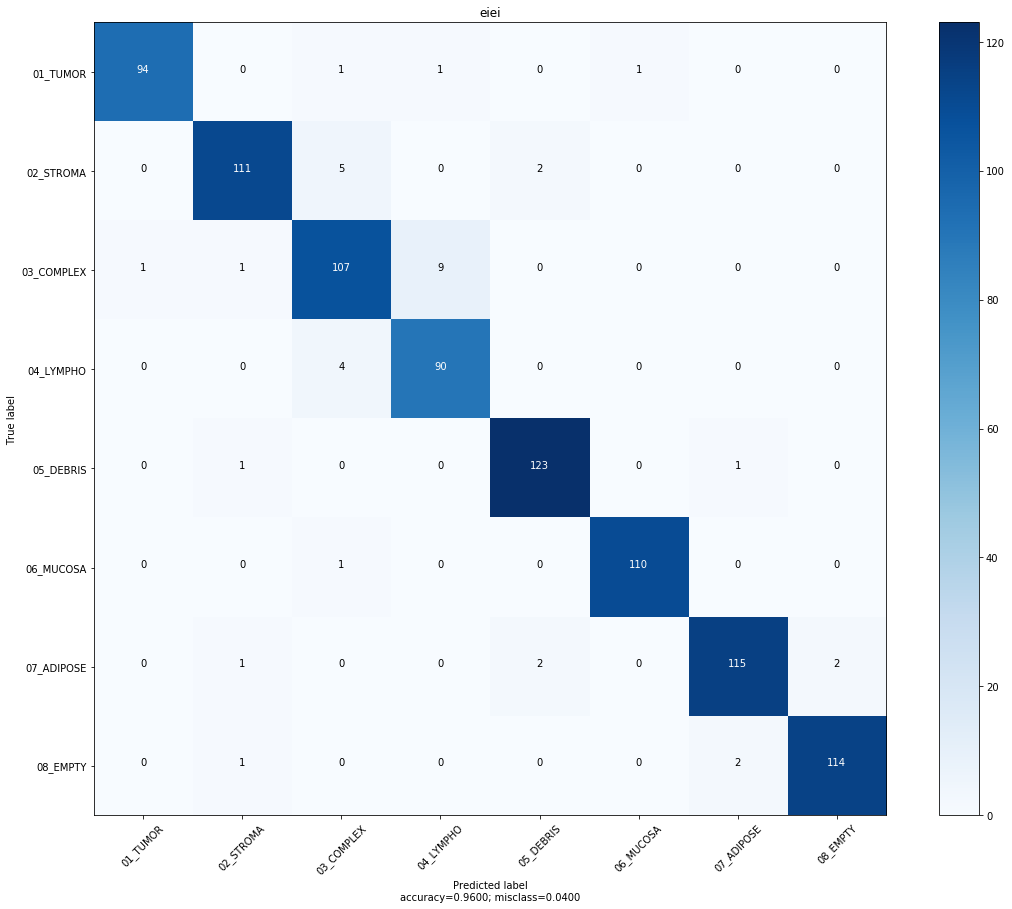

In [23]:
cm = confusion_matrix(final_true, 
                 final_preds, 
                 labels=list(validation_generator.class_indices.keys()))
np.set_printoptions(precision=2)
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cm=cm, normalize=False, target_names=list(validation_generator.class_indices.keys()), title="eiei")
plt.show()

In [24]:
test_generator = test_datagen.flow_from_directory('./test',classes=['test'],target_size=(150,150),
                                                 shuffle=False,
                                                 class_mode=None,
                                                 batch_size=1,
                                                 seed=7)

Found 500 images belonging to 1 classes.


In [25]:
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
test_generator.reset()
pred=saved_model.predict_generator(test_generator,steps=STEP_SIZE_TEST,verbose=1)

500/500 [==============================] - 2s 5ms/step


In [26]:
num_preds = [np.argmax(pred[i,:]) for i in range(pred.shape[0])]
num_name_dict = {v:k for k,v in train_generator.class_indices.items()}
str_preds = [num_name_dict[x] for x in num_preds]
test_file_id = [os.path.basename(test_file) for test_file in test_generator.filenames]
test_submission = pd.DataFrame({'Id': test_file_id, 'Category': str_preds})
test_submission.to_csv('submission.csv', index=False)